In [35]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import poly1d

from brmbs.simulation.DataGenerator import generateSimulatedBDTPrice, callableBond, TestFunctionGenerator
from brmbs.model.OrthogonalRegression import *
import brmbs.data.DataLoader as dl
from brmbs.preprocessing.IssuanceProcessor import RegressionPeriod, get_coupon_periods
from brmbs.simulation.PolynomialSimulation import simulate_poly_fit

%matplotlib inline

In [67]:
df, TBAs, params, all_coupons, rate_Base_raw, FN_issue, rate_Base = dl.load_all_data(data_folder = '../data/')
collapse_without_order, collapse_with_order = get_coupon_periods(df, all_coupons, FN_issue)

data = TBAs[4.5]['2010-01-01':]

prices = data.price.values
rates = data.MTGFNCL.values / 100

ret = (prices[1:] - prices[:-1]) / prices[:-1]
delta_r = rates[1:] - rates[:-1]

dates = data.index[1:]

In [68]:
window = 120
D = []
for t in range(len(delta_r) - window):
    y = ret[t : t+window]
    x = delta_r[t : t+window]
    model = sm.OLS(y, x)
    result = model.fit()
    D.append(- result.params[0])

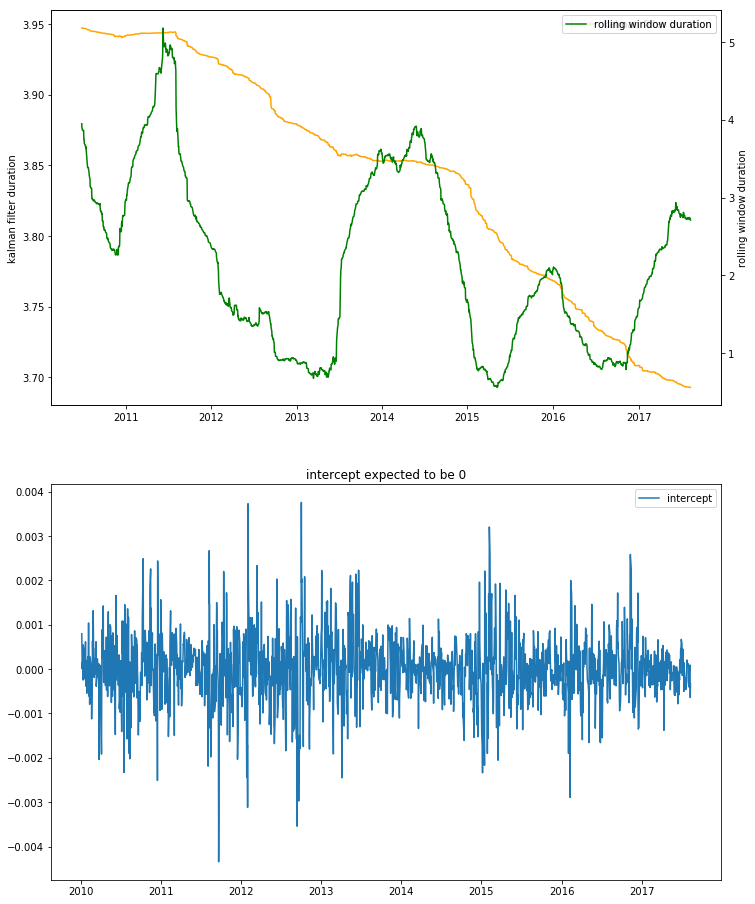

In [90]:
delta = 0.01
trans_cov = np.std(D)*np.eye(2) # How much random walk wiggles
obs_mat = np.expand_dims(np.vstack([[delta_r], [np.ones(len(delta_r))]]).T, axis=1)

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, 
                  initial_state_mean=[-D[0],0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=2,
                  transition_covariance=trans_cov)

state_means, state_covs = kf.filter(ret)

fig = plt.figure(figsize = (12, 16))
ax1 = fig.add_subplot(211)
ax1.plot(dates[120:], -1 * state_means[:,0][120:], label='kalman filter duration', c = 'orange')
ax1.set_ylabel('kalman filter duration')
ax11 = ax1.twinx()
ax11.plot(dates[120:], D, label='rolling window duration', c = 'green')
ax11.set_ylabel('rolling window duration')
ax1.legend()
ax11.legend()
ax2 = fig.add_subplot(212)
ax2.plot(dates, state_means[:,1], label='intercept')
ax2.set_title('intercept expected to be 0')
ax2.legend()